In [8]:
# MO444-A 2s/2017 - Third assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold

def loadIDs():
    lines=[]
    with open('documents/ids', "r") as f:
        lines = f.read().splitlines()
    return np.asarray(lines)

def loadFeatures():
    features = pd.read_csv('documents/data.csv', sep=',', header=None)
    return features.values

def loadDocument(docID):
    data = None
    with open('documents/docs/' + docID, 'r') as docfile:
        data = docfile.read().replace('\n', '')
    return data

def runKFoldClustering(model, data):
    random_state = np.random.RandomState(1)
    k5_fold = KFold(n_splits=5, shuffle=True, random_state=random_state)
    costs = []
    for train_index, validation_index in k5_fold.split(data):
        train_data, validation_data = data[train_index], data[validation_index]
        model.fit(train_data)
        model.predict(validation_data)
        costs.append(model.inertia_)
    return np.mean(costs), np.std(costs)


In [4]:
ids = loadIDs()
print('IDs shape: {}'.format(ids.shape))

data = loadFeatures()
print('Data shape: {}'.format(data.shape))

IDs shape: (19924,)
Data shape: (19924, 2209)


In [3]:
# Let's look at the 5 first instances of the IDs
print(ids[0:5])

['832e15531654188fa0b951faa5f68540dfb1ca5a'
 'aa5163928a6edfd3bf69fd11fe763aacecf4602d'
 'e886703afff0c70d6598bcae0c2d69a5a237807f'
 'c1ea507b177b2e1673ce7a576057f91b75ae9d29'
 'bbf73405c85d22702fafc1c0916e8f713810ff8d']


In [4]:
# Now, let's have a look at the 5 first instances of the data (bag-of-words feature vectors)
data_frame = pd.DataFrame(data)
data_frame.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2199,2200,2201,2202,2203,2204,2205,2206,2207,2208
0,0.077257,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.055755,0.0,0.0
2,0.042250,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.093693,0.0,0.099296,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.069105,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.036811,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.000000,0.041917,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [5]:
# Checking the value ranges
print('Min. value: {}'.format(np.min(data.flatten())))
print('Max. value: {}'.format(np.max(data.flatten())))

# Let's scale and normalize the data
data = scale(data)

normalizer = Normalizer()
normalizer = normalizer.fit(data)

data = normalizer.transform(data)

Min. value: 0.0
Max. value: 0.999901


In [6]:
# Attempting Mini-Batch K means with some different number of centroids.
num_centroids = xrange(149, 154)
kmeans = [MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=1000, random_state=1) for i in num_centroids]

start_time = datetime.now()
costs, labels = [], []
for i in range(len(kmeans)):
    labels.append(kmeans[i].fit_predict(data))
    costs.append(kmeans[i].inertia_)

print('Elapsed time: {}'.format(datetime.now() - start_time))

Elapsed time: 0:00:30.171268


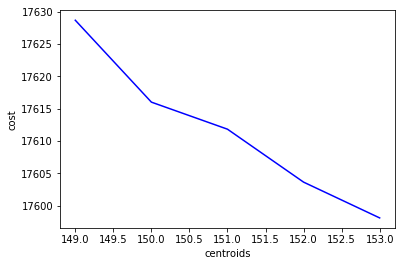

In [7]:
# Plot an elbow curve.
plt.plot(num_centroids, costs, color='blue')
plt.xlabel('centroids')
plt.ylabel('cost')
plt.show()

2 clusters: Cost 14523.33 ±11.23
4 clusters: Cost 14255.30 ±50.67
8 clusters: Cost 13914.44 ±28.60
16 clusters: Cost 13486.94 ±42.67
32 clusters: Cost 12819.08 ±34.20
64 clusters: Cost 11995.90 ±53.97
128 clusters: Cost 11184.01 ±37.12
256 clusters: Cost 10555.65 ±33.36


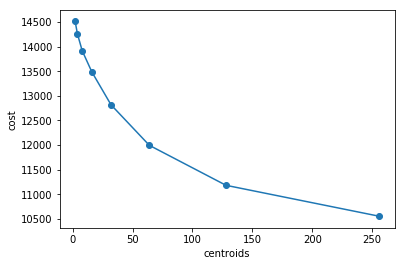

In [45]:
costs, costs_sd = [], []
num_centroids_2 = [2, 4, 8, 16, 32, 64, 128, 256]
for i in num_centroids_2:
    model = MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=1000, random_state=1)
    cost_mean, cost_sd = runKFoldClustering(model, data)
    costs.append(cost_mean)
    costs_sd.append(cost_sd)
    print '%d clusters: Cost %5.2f ±%5.2f' % (i, cost_mean, cost_sd)

# Plot an elbow curve.
plt.plot(color='blue', marker='o')
plt.errorbar(num_centroids_2, costs, yerr=costs_sd, 
             fmt='-o', ecolor='r', capthick=2)
plt.xlabel('centroids')
plt.ylabel('cost')
plt.show()

In [8]:
# Check the silhouette scores.
start_time = datetime.now()
sil_avgs, sil_avgs_centroids = [], []
for i in range(len(kmeans)):
    sil_avg = silhouette_score(data, labels[i])
    print('centroids: %d, silhouette average: %f' % (kmeans[i].n_clusters, sil_avg))
    sil_avgs.append(sil_avg)
    sil_avgs_centroids.append(kmeans[i].n_clusters)

print('Elapsed time: {}'.format(datetime.now() - start_time))

centroids: 149, silhouette average: 0.022329
centroids: 150, silhouette average: 0.021166
centroids: 151, silhouette average: 0.023733
centroids: 152, silhouette average: 0.023451
centroids: 153, silhouette average: 0.023226
Elapsed time: 0:01:50.787880


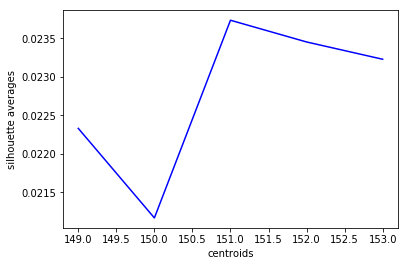

In [9]:
# Plot the silhouette averages
plt.plot(sil_avgs_centroids, sil_avgs, color='blue')
plt.xlabel('centroids')
plt.ylabel('silhouette averages')
plt.show()

In [10]:
# Chosen number of centroids: 151
chosen_model = kmeans[2]
chosen_model_labels = labels[2]

In [11]:
# Let's check three sample groups, their medoid documents, and two other closer documents.
for i in [24, 48, 72]:
    print('Group: %d' % i)
    center = chosen_model.cluster_centers_[i]
    group_points = data[chosen_model_labels == i]
    group_doc_ids = ids[chosen_model_labels == i]

    # Let's find the medoid and their closest points
    distancesMatrix = pairwise_distances(group_points, metric='euclidean')
    closest_to_medoid_indexes = np.argsort(distancesMatrix.sum(axis=0))
    medoid_index = closest_to_medoid_indexes[0]

    print(' - Medoid doc: {}'.format(group_doc_ids[medoid_index]))
    print(loadDocument(group_doc_ids[medoid_index]))
    print(' - ')
    print(' -- Closest to medoid doc: {}'.format(group_doc_ids[closest_to_medoid_indexes[1]]))
    print(loadDocument(group_doc_ids[closest_to_medoid_indexes[1]]))
    print(' -- ')
    print(' --- Second closest to medoid doc: {}'.format(group_doc_ids[closest_to_medoid_indexes[2]]))
    print(loadDocument(group_doc_ids[closest_to_medoid_indexes[2]]))
    print(' --- ')

Group: 24
 - Medoid doc: 633594b5d24305e8f2e86689322c79ab2dba947f
Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53115 talk.religion.misc:83573 talk.origins:40872Newsgroups: alt.atheism,talk.religion.misc,talk.originsPath: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!zaphod.mps.ohio-state.edu!uwm.edu!ux1.cso.uiuc.edu!news.cso.uiuc.edu!alexia!cobbFrom: cobb@alexia.lis.uiuc.edu (Mike Cobb)Subject: Re: After 2000 years, can we say that Christian Morality is Date: Thu, 15 Apr 1993 22:48:49 GMTMessage-ID: <C5JrDE.M4z@news.cso.uiuc.edu>References: <4fm9iYO00iV303voYt@andrew.cmu.edu> <C5Fuo2.FF8@news.cso.uiuc.edu> Sender: usenet@news.cso.uiuc.edu (Net Noise owner)Organization: University of Illinois at UrbanaLines: 13Theory of Creationism: MY theistic view of the theory of creationism, (there are many others) is stated in Genesis 1.  In the beginning God createdthe heavens and the earth.MAC--****************************************************************   